## Importing necessary libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

2025-10-26 17:50:32.505630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 17:50:32.515714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 17:50:32.527430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 17:50:32.530774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-26 17:50:32.539748: I tensorflow/core/platform/cpu_feature_guar

## Image Data Preprocessing

> **Data Loading**

In [3]:
img_h = 224
img_w = 224
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
train_ds = image_dataset_from_directory("images/data/train",
                                        image_size=(img_h, img_w),
                                        batch_size=batch_size,
                                        label_mode='categorical')

val_ds = image_dataset_from_directory("images/data/val",
                                      image_size=(img_h, img_w),
                                      batch_size=batch_size,
                                      label_mode='categorical')

test_ds = image_dataset_from_directory("images/data/test",
                                       image_size=(img_h, img_w),
                                       batch_size=batch_size,
                                       label_mode='categorical',
                                       shuffle=False)

Found 6225 files belonging to 11 classes.
Found 1092 files belonging to 11 classes.


I0000 00:00:1761481234.973069  156178 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-26 17:50:35.125713: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 3187 files belonging to 11 classes.


In [5]:
## Augmenting the training data

augment = Pipeline([tf.keras.layers.RandomRotation(0.2),
                    tf.keras.layers.RandomZoom(0.2),
                    tf.keras.layers.RandomFlip("horizontal")])

In [6]:
def prepare(ds, shuffle=False, apply_augment=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()
    if shuffle: 
        ds = ds.shuffle(1000) 
    if apply_augment: 
        ds = ds.map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_fds = prepare(train_ds, shuffle=True, apply_augment=True)
val_fds = prepare(val_ds)
test_fds = prepare(test_ds)    

## Model Training

> **Pre-trained ResNet50 Model**

In [7]:
# Loading pre-trained ResNet50 Model

base_model = ResNet50(weights="imagenet", 
                      include_top=False,
                      input_shape=(img_h, img_w, 3))

In [8]:
# Freeze all layers

base_model.trainable = False

In [9]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
## Building Layers of Pre-trained ResNet50 Model

inputs = Input(shape=(img_h, img_w, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D() (x)
x = Dropout(0.5)(x)                     
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(0.3)(x)  
outputs = Dense(train_fds.element_spec[1].shape[-1], activation="softmax") (x)

In [11]:
## Creating Customized ResNet50 Model

pre_trained_resnet50_model = Model(inputs, outputs)

In [12]:
pre_trained_resnet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,642,443 (94.00 MB)

 Trainable params: 1,054,731 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)

check_point = ModelCheckpoint(filepath="Trained Models/best_resnet50_model_pretune.keras",
                              monitor="val_loss",
                              save_best_only=True,
                              save_weights_only=False,
                              verbose=1)

In [14]:
pre_trained_resnet50_model.compile(optimizer="adam",
                                   loss="categorical_crossentropy",
                                   metrics=["accuracy"])

bf_resnet50_history = pre_trained_resnet50_model.fit(train_fds,
                                                     validation_data=val_fds,
                                                     epochs=5,
                                                     callbacks=[early_stopping, check_point])

Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.6984 - loss: 1.1100
Epoch 1: val_loss improved from None to 0.15817, saving model to Trained Models/best_resnet50_model_pretune.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.8347 - loss: 0.6079 - val_accuracy: 0.9808 - val_loss: 0.1582
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.9157 - loss: 0.3410
Epoch 2: val_loss improved from 0.15817 to 0.15290, saving model to Trained Models/best_resnet50_model_pretune.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9256 - loss: 0.3186 - val_accuracy: 0.9780 - val_loss: 0.1529
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.9461 - loss: 0.2507
Epoch 3: val_loss did not improve from 0.15290
195/195 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9489 - loss: 0.2435 - val_accuracy: 0.9789 - val_loss: 0.1615
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9441 - loss: 0.2461
Epoch 4: val_loss im

In [15]:
bf_train_accuracy = bf_resnet50_history.history['accuracy']
bf_train_loss = bf_resnet50_history.history['loss']

bf_val_accuracy = bf_resnet50_history.history['val_accuracy']
bf_val_loss = bf_resnet50_history.history['val_loss']

bf_epochs = range(1, len(bf_train_accuracy)+1)

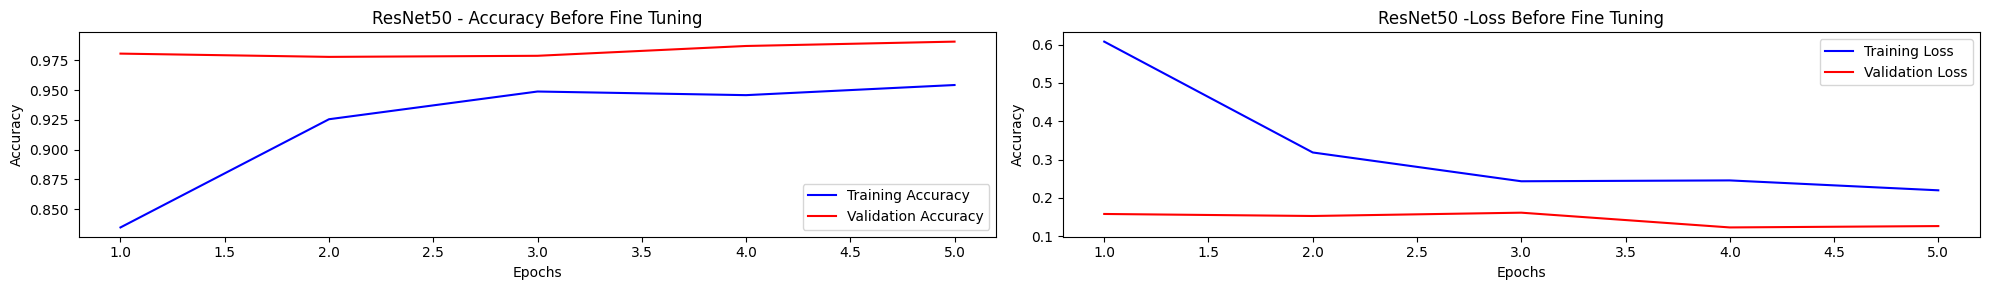

In [16]:
plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
plt.plot(bf_epochs, bf_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(bf_epochs, bf_val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet50 - Accuracy Before Fine Tuning")

plt.subplot(1,2,2)
plt.plot(bf_epochs, bf_train_loss, 'b-', label='Training Loss')
plt.plot(bf_epochs, bf_val_loss, 'r-', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet50 -Loss Before Fine Tuning")

plt.tight_layout()
plt.show()

In [17]:
pre_trained_resnet50_model.save('Trained Models/multiclass_fish_before_finetune_pretrained_resnet50_model.keras') ## latest saving method for DL

## Fine-Tuning Pre-Trained ResNet Model

In [18]:
## Unfreezing Last Covolutional Layers in RessNet50

for layer in base_model.layers:
    if layer.name.startswith('conv5_block'):
        layer.trainable = True

In [19]:
check_point1 = ModelCheckpoint(filepath="Trained Models/best_resnet50_model_finetuned.keras",
                               monitor="val_loss",
                               save_best_only=True,
                               save_weights_only=False,
                               verbose=1)

In [20]:
## Setting Lesser Learning Rate and Increasing epochs

pre_trained_resnet50_model.compile(optimizer=Adam(learning_rate=1e-5),
                                   loss="categorical_crossentropy",
                                   metrics=["accuracy"])

af_resnet50_history = pre_trained_resnet50_model.fit(train_fds,
                                                     validation_data=val_fds,
                                                     epochs=10,
                                                     callbacks=[early_stopping, check_point1])

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7285 - loss: 1.1563
Epoch 1: val_loss improved from None to 0.10704, saving model to Trained Models/best_resnet50_model_finetuned.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.8627 - loss: 0.5749 - val_accuracy: 0.9954 - val_loss: 0.1070
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9721 - loss: 0.1731
Epoch 2: val_loss improved from 0.10704 to 0.10423, saving model to Trained Models/best_resnet50_model_finetuned.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.9765 - loss: 0.1615 - val_accuracy: 0.9945 - val_loss: 0.1042
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9813 - loss: 0.1360
Epoch 3: val_loss improved from 0.10423 to 0.10365, saving model to Trained Models/best_resnet50_model_finetuned.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9839 - loss: 0.1322 - val_accuracy: 0.9945 - val_loss: 0.1036
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━

In [21]:
af_train_accuracy = af_resnet50_history.history['accuracy']
af_train_loss = af_resnet50_history.history['loss']

af_val_accuracy = af_resnet50_history.history['val_accuracy']
af_val_loss = af_resnet50_history.history['val_loss']

epochs = range(1, len(af_train_accuracy)+1)

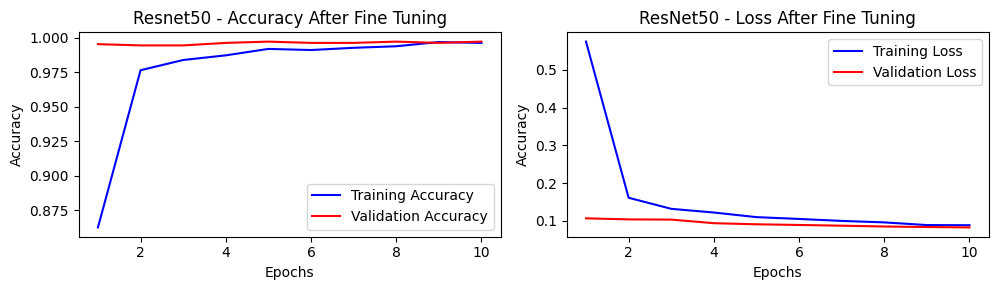

In [22]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(epochs, af_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, af_val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Resnet50 - Accuracy After Fine Tuning")

plt.subplot(1,2,2)
plt.plot(epochs, af_train_loss, 'b-', label='Training Loss')
plt.plot(epochs, af_val_loss, 'r-', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet50 - Loss After Fine Tuning")

plt.tight_layout()
plt.show()

In [23]:
pre_trained_resnet50_model.save('Trained Models/multiclass_fish_pretrained_resnet50_model.keras') ## latest saving method for DL

## Model Evaluation

> **Model Testing**

In [24]:
# Evaluating model based on accuracy

resnet50_loss, resnet50_accuracy = pre_trained_resnet50_model.evaluate(test_fds)
resnet50_accuracy

100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 898ms/step - accuracy: 0.9981 - loss: 0.0821


0.9981173276901245

> **Finding Prediction Classes**

In [25]:
# Getting Predictions Probabilities and Predicted Classes

y_probs = pre_trained_resnet50_model.predict(test_fds)
y_pred = np.argmax(y_probs, axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 869ms/step


In [26]:
## Getting True Classes

y_true_list = []
for _, label_batch in test_fds:
    y_true_list.extend(label_batch.numpy().tolist())
y_true = np.argmax(y_true_list, axis=1)

2025-10-26 19:08:53.844656: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
print(y_pred.shape)
print(y_true.shape)

(3187,)
(3187,)


In [28]:
# Other Performance Metrics Calculations

resnet50_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
resnet50_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
resnet50_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
resnet50_cm = confusion_matrix(y_true, y_pred)

In [29]:
print("ResNet50 Model - After FineTuning Performance Metrics:\n")
print(f" Accuracy : {resnet50_accuracy*100:.4f}%")
print(f" Loss     : {resnet50_loss:.4f}")
print(f" Precision: {resnet50_precision:.4f}")
print(f" Recall   : {resnet50_recall:.4f}")
print(f" F1 Score : {resnet50_f1:.4f}")

ResNet50 Model - After FineTuning Performance Metrics:

 Accuracy : 99.8117%
 Loss     : 0.0821
 Precision: 0.9981
 Recall   : 0.9981
 F1 Score : 0.9981


In [30]:
class_indices = {class_name : index for index, class_name in enumerate(test_ds.class_names)}
print(class_indices)

{'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


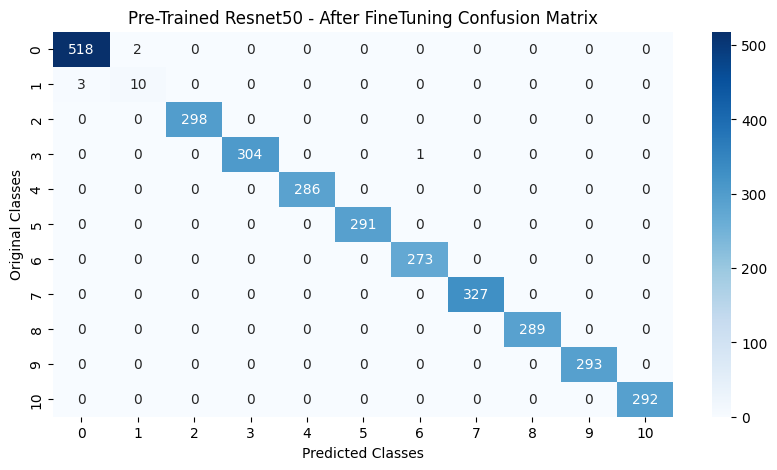

In [31]:
plt.figure(figsize=(10,5))
sns.heatmap(resnet50_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Classes")
plt.ylabel("Original Classes")
plt.title("Pre-Trained Resnet50 - After FineTuning Confusion Matrix")
plt.show()

In [32]:
classes = test_ds.class_names

In [33]:
# Classification Report (per-class)

resnet50_cr = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
print(resnet50_cr)

                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      1.00       520
                animal fish bass       0.83      0.77      0.80        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           1.00      3187
                       macro avg    